In [2]:
import io
from IPython.nbformat import current
def execute_notebook(nbfile):
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    ip = get_ipython()
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
execute_notebook("/cellar/users/ramarty/Projects/hla_ii/bin/imports.ipynb")

Populating the interactive namespace from numpy and matplotlib


## Predicting if a patient will get a mutation <br>
1. In comparison to how everyone else presents that mutation
2. In comparison to all of their other PHBR scores

#### Comparison of single mutation across all patients

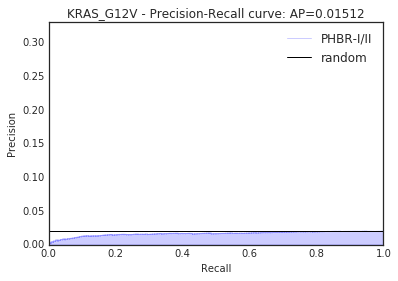

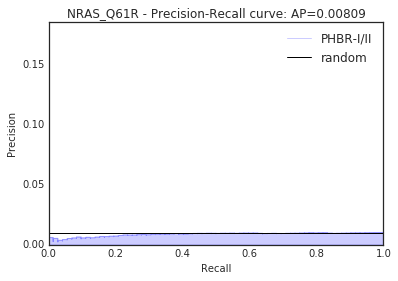

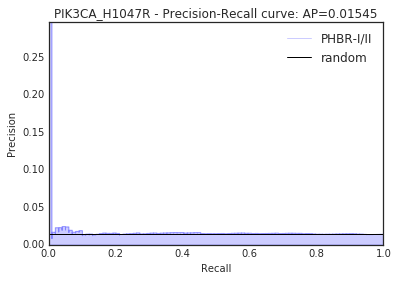

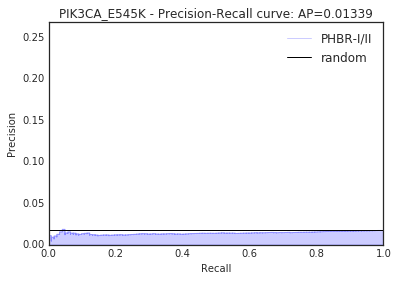

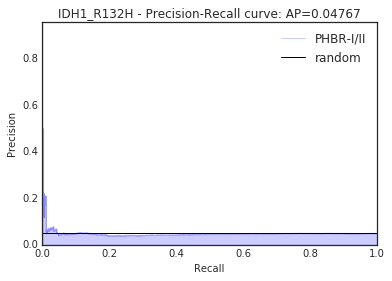

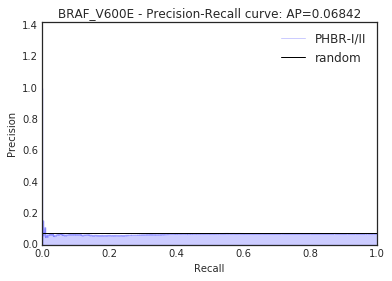

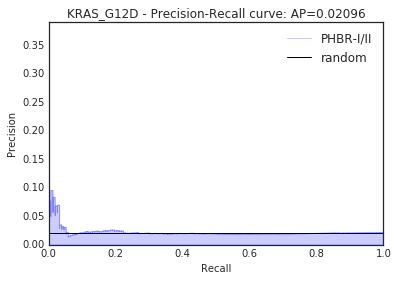

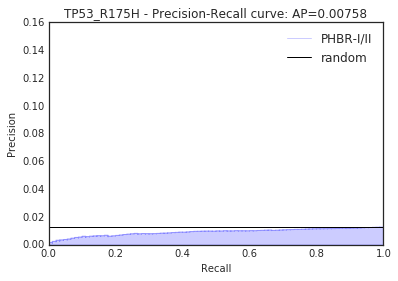

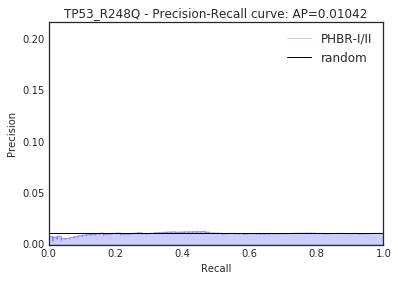

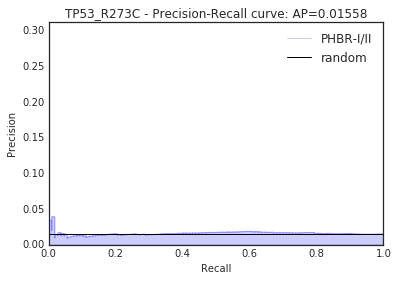

In [3]:
mutations = [x.split('.')[0] for x in os.listdir('/cellar/users/ramarty/Data/hla_ii/generated_data/predictions/')]
for mutation in mutations:
    df = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/generated_data/predictions/{0}.data.txt'.format(mutation),
                       sep=' ')
    precision, recall, thresholds = metrics.precision_recall_curve(df.label, df.predicted_prob)

    random = float(len(df[df.label == 1]))/len(df)

    plt.step(recall, precision, color='b', alpha=0.2,
                 where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    plt.axhline(random, c='k')

    plt.legend(('PHBR-I/II', 'random',))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, np.median(precision)*20.0])
    plt.xlim([0.0, 1.0])
    plt.title('{0} - Precision-Recall curve: AP={1}'.format(mutation, round(np.mean(precision), 5)))
    plt.savefig('/cellar/users/ramarty/Data/hla_ii/generated_figures/matched_models/predictions/specific_mutations/{0}.single_comparison.pdf'.format(mutation))
    plt.show()
    plt.clf()

#### Comparison of all mutations across all patients

In [47]:
patient_PHBRs = pd.concat([pd.concat([classI.transpose(), classII.transpose()]).transpose()])

In [74]:
mutations = patient_mutations.sum().sort_values(ascending=False)[:10].index

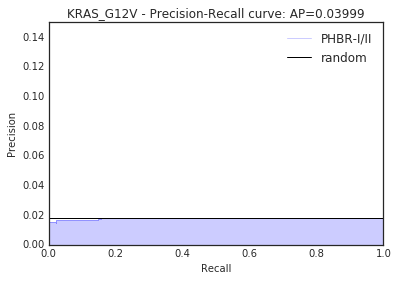

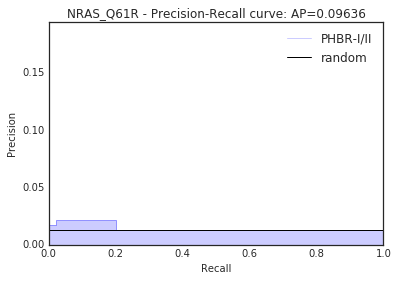

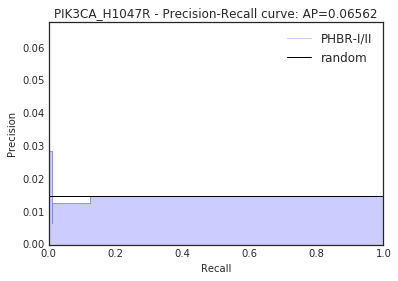

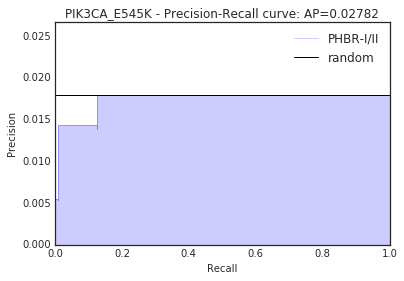

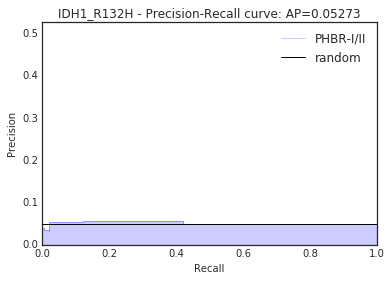

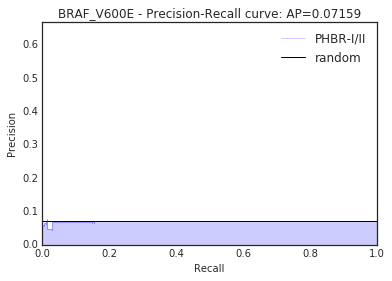

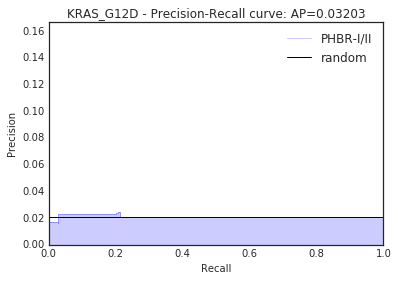

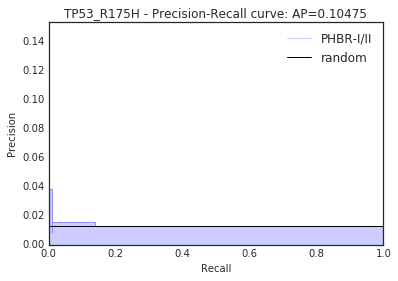

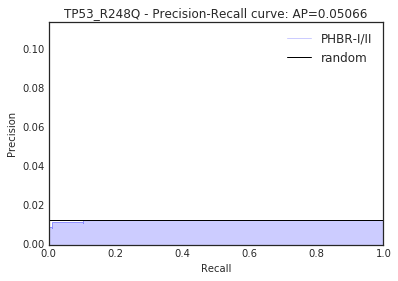

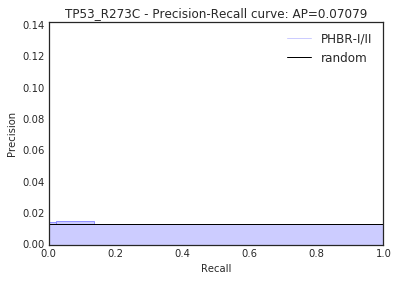

In [71]:
# Train predictor
for mutation in mutations:
    patients_with = list(patient_mutations[patient_mutations[mutation] == 1].index)

    # not quite right
    X = patient_PHBRs.as_matrix()
    Y = patient_mutations.ix[:, mutation]

    skf = StratifiedKFold(n_splits=10, shuffle=True)
    positives, negatives = [], []
    positives_prob, negatives_prob = [], []
    for train, test in skf.split(X, Y):
        weight_shift = float(len(Y[train][Y[train] == 0]))/len(Y[train][Y[train] == 1])
        clf = RandomForestClassifier(random_state=0, class_weight={1:weight_shift, 0:1})
        clf.fit(X[train], Y[train])
        df = pd.DataFrame(X[test])
        df['positive'] = list(Y[test].astype(bool))
        positives.extend(clf.predict(df[df['positive']].ix[:, :2036].as_matrix()))
        negatives.extend(clf.predict(df[~df['positive']].ix[:, :2036].as_matrix()))
        positives_prob.extend(clf.predict_proba(df[df['positive']].ix[:, :2036].as_matrix()))
        negatives_prob.extend(clf.predict_proba(df[~df['positive']].ix[:, :2036].as_matrix()))

    df = pd.DataFrame({'label': [1 for x in positives_prob] + [0 for x in negatives_prob],
                      'prediction': [x[1] for x in positives_prob] + [x[1] for x in negatives_prob]})
    precision, recall, thresholds = metrics.precision_recall_curve(df.label, df.prediction)
    random = float(len(df[df.label == 1]))/len(df)
    plt.step(recall, precision, color='b', alpha=0.2,
                 where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    plt.axhline(random, c='k')

    plt.legend(('PHBR-I/II', 'random',))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, np.median(precision)*10.0])
    plt.xlim([0.0, 1.0])
    plt.title('{0} - Precision-Recall curve: AP={1}'.format(mutation, round(np.mean(precision), 5)))
    plt.show()

#### Comparison to rest of driver space for that patient <br>
Rank each patient for percentile of mutation and then compare percentiles for those who did and didn't get it

In [4]:
patient_mutations = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/combined_classes/patient_mutations.csv', index_col=0)
classI = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/combined_classes/patient_affinities.class_i.csv', index_col=0)
classII = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/combined_classes/patient_affinities.class_ii.csv', index_col=0)

In [18]:
mutation = 'BRAF_V600E'
patient = 'TCGA-DH-A7UV'

In [33]:
for mutation in patient_mutations.sum().sort_values(ascending=False)[:10].index:
    mutated, not_mutated = [], []
    for patient in patient_mutations.index:
        tmp = pd.DataFrame(classI.ix[patient].sort_values()).reset_index()
        tmp.columns = ['mutation', 'PHBR']
        tmp['order'] = tmp.index
        tmp.index = tmp.mutation
        if patient_mutations.ix[patient, mutation] == 0:
            not_mutated.append(tmp.ix[mutation]['order'])
        else:
            mutated.append(tmp.ix[mutation]['order'])
    print mutation, np.mean(mutated), np.mean(not_mutated), sp.mannwhitneyu(mutated, not_mutated)

BRAF_V600E 814.724271845 809.970928463 MannwhitneyuResult(statistic=1663498.5, pvalue=0.26349874420381869)
IDH1_R132H 751.893557423 751.377972652 MannwhitneyuResult(statistic=1196719.5, pvalue=0.45530608049551619)
KRAS_G12D 816.213793103 814.834293948 MannwhitneyuResult(statistic=499412.5, pvalue=0.43907947309655299)
KRAS_G12V 590.9765625 603.279862009 MannwhitneyuResult(statistic=416565.0, pvalue=0.10550114876737082)
PIK3CA_E545K 721.385826772 722.272348376 MannwhitneyuResult(statistic=439844.5, pvalue=0.46532419763778443)
PIK3CA_H1047R 606.962264151 628.343602235 MannwhitneyuResult(statistic=333513.0, pvalue=0.040901902287192371)
TP53_R273C 692.229166667 736.446988124 MannwhitneyuResult(statistic=271760.0, pvalue=0.00068508625659144504)
NRAS_Q61R 595.393617021 606.43884995 MannwhitneyuResult(statistic=319724.0, pvalue=0.32657497260646007)
TP53_R175H 804.344086022 798.241704805 MannwhitneyuResult(statistic=321191.0, pvalue=0.42039161075590892)
TP53_R248Q 514.511363636 513.121623553 Ma

In [34]:
for mutation in patient_mutations.sum().sort_values(ascending=False)[:10].index:
    mutated, not_mutated = [], []
    for patient in patient_mutations.index:
        tmp = pd.DataFrame(classII.ix[patient].sort_values()).reset_index()
        tmp.columns = ['mutation', 'PHBR']
        tmp['order'] = tmp.index
        tmp.index = tmp.mutation
        if patient_mutations.ix[patient, mutation] == 0:
            not_mutated.append(tmp.ix[mutation]['order'])
        else:
            mutated.append(tmp.ix[mutation]['order'])
    print mutation, np.mean(mutated), np.mean(not_mutated), sp.mannwhitneyu(mutated, not_mutated)

BRAF_V600E 795.970873786 799.766971081 MannwhitneyuResult(statistic=1589880.5, pvalue=0.011314118397603837)
IDH1_R132H 760.170868347 763.450505351 MannwhitneyuResult(statistic=1164323.5, pvalue=0.16540183145457293)
KRAS_G12D 487.710344828 501.110518732 MannwhitneyuResult(statistic=472697.0, pvalue=0.10578533309150684)
KRAS_G12V 400.953125 387.454362513 MannwhitneyuResult(statistic=424696.5, pvalue=0.18507027667668663)
PIK3CA_E545K 677.74015748 674.187697614 MannwhitneyuResult(statistic=432825.0, pvalue=0.34666972797571988)
PIK3CA_H1047R 428.886792453 435.947127096 MannwhitneyuResult(statistic=348029.0, pvalue=0.14782630147030829)
TP53_R273C 897.697916667 895.010444985 MannwhitneyuResult(statistic=312465.5, pvalue=0.12385896013605846)
NRAS_Q61R 783.14893617 775.045487055 MannwhitneyuResult(statistic=305398.5, pvalue=0.11967224865627124)
TP53_R175H 847.408602151 847.059925629 MannwhitneyuResult(statistic=319690.5, pvalue=0.39070362436306172)
TP53_R248Q 516.852272727 485.64141775 Mannwhit